<a href="https://colab.research.google.com/github/how-to-train-your-model/data-science-portfolio/blob/main/Module_8_Assignment_1_Dogs_vs_Cats_Redux_Kernel_Edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 8: Dogs vs. Cats Redux: Kernel Edition 

### Author: Pankaj Pant









Importing Packages

In [ ]:
!pip install pathlib2


# Import Packages

In [ ]:
import os
from pathlib2 import Path
import zipfile
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from tqdm import tqdm
from PIL import Image, ImageFilter
from IPython.display import display
import cv2

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report



In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [ ]:
# Allows for muliple output in one cell window
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Allows for viewing the complete data in a single window 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Data Ingestion
### Connect to google drive and import training and test data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -l "/content/drive/My Drive/Colab_Notebooks/MSDS-422/W8"

total 837729
-rw------- 1 root root   1037710 Feb 23 19:49 'Credit_Card_Fraud_Detection-Solution (1).ipynb'
drwx------ 2 root root      4096 Feb 24 05:44  data
-rw------- 1 root root    643913 Feb 23 20:02 'Flight_Delay-Solution (1).ipynb'
-rw------- 1 root root    915693 Feb 25 23:28 'Module1_Assignment8_Group5 (1).ipynb'
-rw------- 1 root root    703443 Feb 26 15:47 'Module 8 Assignment 1: Dogs vs. Cats Redux: Kernel Edition.ipynb'
-rw------- 1 root root       143 Feb 26 15:44 'Module 8: Dogs vs. Cats Redux: Kernel Edition .gdoc'
-rw------- 1 root root    113903 Feb 24 01:40  sample_submission.csv
drwx------ 2 root root      4096 Feb 24 12:25  test
drwx------ 2 root root      4096 Feb 24 05:46  test1
-rw------- 1 root root 284478493 Feb 24 01:40  test.zip
drwx------ 2 root root      4096 Feb 24 12:26  train
drwx------ 2 root root      4096 Feb 24 05:45  train1
-rw------- 1 root root 569918665 Feb 24 01:40  train.zip


In [ ]:
#Generalize the file path 
w8_files = "/content/drive/My Drive/Colab_Notebooks/MSDS-422/W8"

In [ ]:
base_path = '/content/drive/My Drive/Colab_Notebooks/MSDS-422/W8'
csv_base_path = '/content/drive/My Drive/Colab_Notebooks/MSDS-422/W8'
file_path = 'train.zip'

In [ ]:
zip_files = [str(file) for file in list(Path(base_path).iterdir()) if '.zip' in str(file)]
len(zip_files)

2

In [ ]:
# def zip2csv(zipFile_name , file_path = '/content/drive/My Drive/Colab_Notebooks/MSDS-422/W8'):
#     """
#     Extract csv from zip files
#     zipFile_name: name of the zip file
#     file_path : name of the folder to store csv
#     """
#     try:
#         with ZipFile(zipFile_name, 'r') as z: 
#             print(f'Extracting {zipFile_name} ') 
#             z.extractall(path=file_path) 
#     except:
#         print(f'zip2csv failed for {zipFile_name}')

# for file in zip_files:
#     zip2csv(file)

# print("Files Extracted")

In [ ]:

# csv_files = [str(file) for file in list(Path(csv_base_path).iterdir()) if '.csv' in str(file)]
# len(csv_files)

In [ ]:
base_dir = '/content/drive/My Drive/Colab_Notebooks/MSDS-422/W8'
train_dir = '../data/train'
test_dir = '../data/test'

In [ ]:
os.makedirs('/content/drive/My Drive/Colab_Notebooks/MSDS-422/W8/data', exist_ok=True)

In [ ]:
%%time
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')

CPU times: user 11 s, sys: 4.33 s, total: 15.3 s
Wall time: 25.3 s


In [ ]:
os.listdir(train_dir)[:5]

['dog.1012.jpg',
 'dog.1375.jpg',
 'dog.11960.jpg',
 'dog.4271.jpg',
 'cat.9079.jpg']

In [ ]:
import glob

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [ ]:
len(train_list)

25000

In [ ]:
len(test_list)

12500

(-0.5, 498.5, 374.5, -0.5)

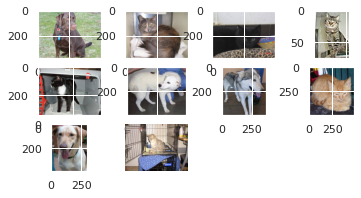

In [ ]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(4,4,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

## Data Extraction

In [ ]:
def label_img(img_name):
  if 'cat' in img_name: return [1, 0]
  elif 'dog' in img_name: return [0, 1]

In [ ]:
train_data = []

with zipfile.ZipFile('/content/drive/My Drive/Colab_Notebooks/MSDS-422/W8/train.zip', 'r') as z:
  for fn in tqdm(z.namelist()):
    if not os.path.isdir(fn) and fn.endswith("jpg"):
      label = label_img(fn)

      img_str = z.read(fn)

      nparr = np.frombuffer(img_str, np.uint8)

      img_np = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
      img = cv2.resize(img_np, (100, 100)) #HXW

      train_data.append([ np.array(img), np.array(label)])

100%|██████████| 25001/25001 [00:41<00:00, 609.34it/s]


In [ ]:
len(train_data)
train_data[1]

25000

[array([[ 43,  44,  43, ...,  94, 183, 193],
        [ 40,  37,  38, ..., 103, 177, 194],
        [ 43,  37,  40, ...,  91, 174, 195],
        ...,
        [ 21,  20,  20, ...,  84,  73,  41],
        [ 24,  18,  21, ...,  59,  39,  30],
        [ 29,  20,  24, ...,  89,  19,  36]], dtype=uint8), array([1, 0])]

## Unzip the files

In [ ]:

! unzip "/content/drive/My Drive/Colab_Notebooks/MSDS-422/W8/train.zip" -d train
! unzip "/content/drive/My Drive/Colab_Notebooks/MSDS-422/W8/test.zip" -d test

Streaming output truncated to the last 5000 lines.
  inflating: test/test/5499.jpg      
  inflating: test/test/55.jpg        
  inflating: test/test/550.jpg       
  inflating: test/test/5500.jpg      
  inflating: test/test/5501.jpg      
  inflating: test/test/5502.jpg      
  inflating: test/test/5503.jpg      
  inflating: test/test/5504.jpg      
  inflating: test/test/5505.jpg      
  inflating: test/test/5506.jpg      
  inflating: test/test/5507.jpg      
  inflating: test/test/5508.jpg      
  inflating: test/test/5509.jpg      
  inflating: test/test/551.jpg       
  inflating: test/test/5510.jpg      
  inflating: test/test/5511.jpg      
  inflating: test/test/5512.jpg      
  inflating: test/test/5513.jpg      
  inflating: test/test/5514.jpg      
  inflating: test/test/5515.jpg      
  inflating: test/test/5516.jpg      
  inflating: test/test/5517.jpg      
  inflating: test/test/5518.jpg      
  inflating: test/test/5519.jpg      
  inflating: test/test/552.jpg       

In [ ]:
# creating dataframe

# labels
file = os.listdir("./train/train")
Labels = list(map(lambda x: x.split('.')[0], file))

In [ ]:
# for filenames
from pathlib import Path
f = Path("./train/train")
File_Path = list(f.glob(r"**/*.jpg"))

# dataframe
File_Path = pd.Series(File_Path).astype(str)
Labels = pd.Series(Labels)
df = pd.concat([File_Path,Labels],axis=1)
df.columns = ['filename', 'category']

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  25000 non-null  object
 1   category  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [ ]:
df.head()

,filename,category
0,train/train/dog.1012.jpg,dog
1,train/train/dog.1375.jpg,dog
2,train/train/dog.11960.jpg,dog
3,train/train/dog.4271.jpg,dog
4,train/train/cat.9079.jpg,cat


In [ ]:
df['category'].value_counts()

dog    12500
cat    12500
Name: category, dtype: int64

In [ ]:
df.isnull().sum()

filename    0
category    0
dtype: int64

In [ ]:
train_data, valid_data = train_test_split(df, test_size= 0.3, random_state = 42)
print(train_data.shape , valid_data.shape)

(17500, 2) (7500, 2)


# Scaling

In [ ]:
# resetting index

train_data = train_data.reset_index(drop=True)

img_gen = ImageDataGenerator(    
    rotation_range=10,
    rescale=1./255,
    horizontal_flip=True,
)
train_gen = img_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size= (128,128),
    class_mode='categorical',
    batch_size=32,
    shuffle = False
)

Found 17500 validated image filenames belonging to 2 classes.


In [ ]:
train_data.head()

,filename,category
0,train/train/cat.5954.jpg,cat
1,train/train/cat.223.jpg,cat
2,train/train/cat.2071.jpg,cat
3,train/train/cat.6525.jpg,cat
4,train/train/dog.9332.jpg,dog


In [ ]:
valid_data = valid_data.reset_index(drop=True)
valid_gen = img_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size= (128,128),
    class_mode='categorical',
    batch_size=32,
    shuffle = False
)

Found 7500 validated image filenames belonging to 2 classes.


In [ ]:
valid_data.head()

,filename,category
0,train/train/cat.9080.jpg,cat
1,train/train/dog.7276.jpg,dog
2,train/train/dog.580.jpg,dog
3,train/train/cat.6573.jpg,cat
4,train/train/dog.2708.jpg,dog


In [ ]:
# Define share for Keras
input_shape = (128,128,3)

# CNN Models

Correlation operation to capture spatial correlation at very very low level

## M1: 2 Layers CNN
Dropout: A Simple Way to Prevent Neural Networks from Overfitting,

In [ ]:
# creating model
model1 = Sequential()

# Adding layers

# Conv and pooling layers 
model1.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1),input_shape=input_shape))
# Maxpoling - Reducing the dimensions and summarizing the featues over larger area of image - local (edges) to global features (eyes, mouth)
# No padding is required with max pooling
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1),input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=(2, 2)))

#flatten layer
model1.add(Flatten())

# dense layers with dropout
model1.add(Dense(128, activation = 'relu'))
# Dropout: A Simple Way to Prevent Neural Networks from Overfitting
model1.add(Dropout(rate = 0.3))
model1.add(Dense(64, activation = 'relu'))

#output layer
model1.add(Dense(2, activation='softmax'))


In [ ]:
# compile model
model1.compile(optimizer='adam',
              loss="categorical_crossentropy", 
              metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 128)               3

In [ ]:
# preventing overfitting
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# fitting a basic model
history = model1.fit(train_gen,
                    validation_data = valid_gen,
                    epochs = 10,
                    verbose=1, #for animated bar during epoch
                    callbacks = [earlystop, learning_rate_reduction])

Epoch 1/10
547/547 [==============================] - 443s 808ms/step - loss: 0.6550 - accuracy: 0.6175 - val_loss: 0.6244 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - 430s 785ms/step - loss: 0.5877 - accuracy: 0.6981 - val_loss: 0.5518 - val_accuracy: 0.7209 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - 429s 783ms/step - loss: 0.5440 - accuracy: 0.7245 - val_loss: 0.5358 - val_accuracy: 0.7360 - lr: 0.0010
Epoch 4/10
547/547 [==============================] - 428s 782ms/step - loss: 0.5021 - accuracy: 0.7588 - val_loss: 0.4892 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 5/10
547/547 [==============================] - 427s 781ms/step - loss: 0.4634 - accuracy: 0.7844 - val_loss: 0.4587 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 6/10
547/547 [==============================] - 428s 782ms/step - loss: 0.4410 - accuracy: 0.7949 - val_loss: 0.4830 - val_accuracy: 0.7737 - lr: 0.0010
Epoch 7/10
547/547 [==========================

Text(0.5, 1.0, 'Training and Validation Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and Validation Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

<Figure size 432x288 with 0 Axes>

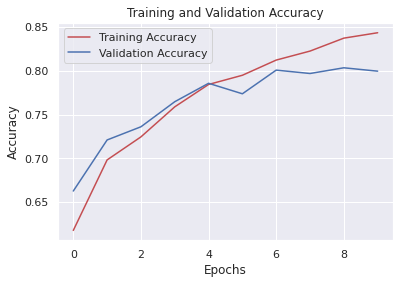

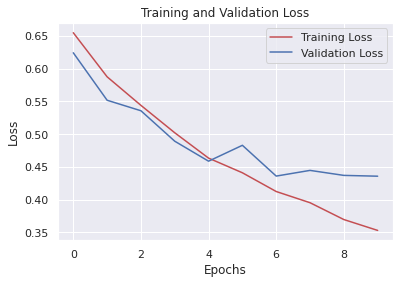

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "upper left")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "upper right")
plt.figure()

In [ ]:
# expected output
y_valid1 = valid_data.category
y_pred1=model1.predict_generator(generator=valid_gen, verbose=1)
pred1 = np.argmax(y_pred1,axis = 1) # pick the class with highest probability
labels = (valid_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred11 = [labels[k] for k in pred1]

235/235 [==============================] - 74s 315ms/step


In [ ]:
print(classification_report(y_valid1, pred11))

              precision    recall  f1-score   support

         cat       0.81      0.79      0.80      3781
         dog       0.79      0.81      0.80      3719

    accuracy                           0.80      7500
   macro avg       0.80      0.80      0.80      7500
weighted avg       0.80      0.80      0.80      7500



Text(0.5, 1.05, 'Confusion Matrix : Actual v/s Predicted')

Text(0.5, 12.5, 'Predicted Value')

Text(30.5, 0.5, 'Actual Value')

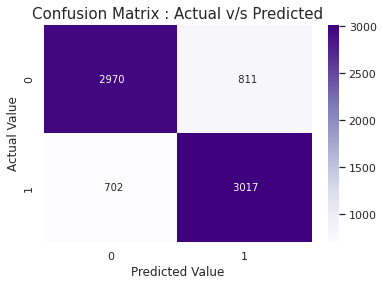

In [ ]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_valid1, pred11),annot=True,fmt='5.0f',cmap="Purples")
plt.title('Confusion Matrix : Actual v/s Predicted', y=1.05, size=15)
#ax = fig.add_subplot(111)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_valid11 = le.fit_transform(y_valid1)
#y_valid1 =  label_img(y_valid)
pred111 = pd.Series(y_pred1[:,1])

<Figure size 1008x504 with 0 Axes>

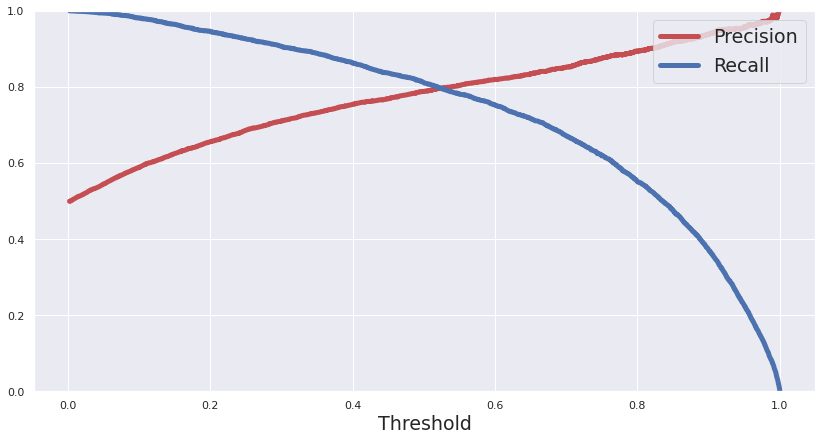

In [ ]:
from sklearn.metrics import precision_recall_curve

#y_scores = best_rfgs.predict_proba(X_valid)
#y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_valid11, pred111)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="Precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="Recall", linewidth=5)
    plt.xlabel("Threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

Although the accuracy is very high, we can see that the training accuracy consistently increase after 10 epochs at a much higher rate compared to the validation epoch indicating a potential overfitting.The Kaggle log loss score for Test dataset was 0.45 ,which further confirms that this model is overfitting on the training dataset and we have scope of tunning it further.

## M2: 3 Layers CNN

In [ ]:
# creating model
model2 = Sequential()

# Adding layers

# 1: Convolution layer with 32 filters, strides
model2.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1),input_shape=input_shape))
# 2: Max pooling layer
model2.add(MaxPooling2D(pool_size=(2, 2)))

# 3: Convolution layer with 64 filter, strides and Max Pooling layer
model2.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1),input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# 4: Convolution layer with 64 filters
model2.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1),input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# 6: Fully-connected 512 node layer
model2.add(Dense(512, activation='relu'))

# 7: Dropout (50%) layer to combat overfitting
model2.add(Dropout(rate = 0.5))

# 8: Fully-connected layer with two outputs
#flatten layer to get the desired two outputs
# This is where Learning takes place
model2.add(Flatten())
model2.add(Dense(2, activation='softmax'))


In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)      

In [ ]:
# fitting a basic model
history2 = model2.fit(train_gen,
                    validation_data = valid_gen,
                    epochs = 10,
                    verbose=1, #for animated bar during epoch
                    callbacks = [earlystop, learning_rate_reduction])

Epoch 1/10
547/547 [==============================] - 599s 1s/step - loss: 0.6477 - accuracy: 0.6262 - val_loss: 0.6079 - val_accuracy: 0.6515 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - 593s 1s/step - loss: 0.5496 - accuracy: 0.7211 - val_loss: 0.5495 - val_accuracy: 0.7189 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - 593s 1s/step - loss: 0.4916 - accuracy: 0.7643 - val_loss: 0.4778 - val_accuracy: 0.7693 - lr: 0.0010
Epoch 4/10
547/547 [==============================] - 602s 1s/step - loss: 0.4479 - accuracy: 0.7937 - val_loss: 0.4395 - val_accuracy: 0.7989 - lr: 0.0010
Epoch 5/10
547/547 [==============================] - 604s 1s/step - loss: 0.4176 - accuracy: 0.8109 - val_loss: 0.3980 - val_accuracy: 0.8233 - lr: 0.0010
Epoch 6/10
547/547 [==============================] - 599s 1s/step - loss: 0.3928 - accuracy: 0.8246 - val_loss: 0.3598 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 7/10
547/547 [==============================] - 596s 1s/st

In [ ]:
# expected output
y_valid = valid_data.category
y_pred=model2.predict_generator(generator=valid_gen, verbose=1)
pred = np.argmax(y_pred,axis = 1) # pick the class with highest probability
labels = (valid_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

235/235 [==============================] - 102s 433ms/step


Text(0.5, 1.0, 'Training and Validation Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and Validation Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

<Figure size 432x288 with 0 Axes>

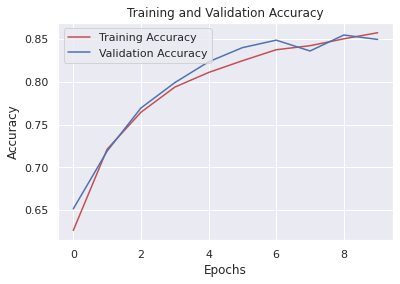

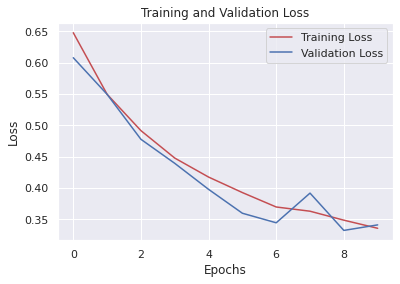

<Figure size 432x288 with 0 Axes>

In [ ]:


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "upper left")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "upper right")
plt.figure()

In [ ]:
print(classification_report(y_valid, pred2))

              precision    recall  f1-score   support

         cat       0.85      0.86      0.85      3781
         dog       0.85      0.84      0.85      3719

    accuracy                           0.85      7500
   macro avg       0.85      0.85      0.85      7500
weighted avg       0.85      0.85      0.85      7500



Text(0.5, 1.05, 'Confusion Matrix : Actual v/s Predicted')

Text(0.5, 12.5, 'Predicted Value')

Text(30.5, 0.5, 'Actual Value')

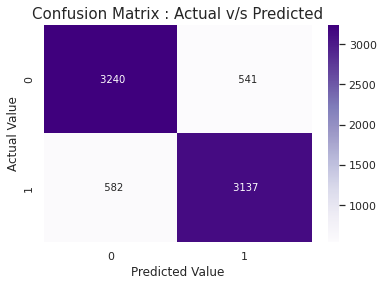

In [ ]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_valid, pred2),annot=True,fmt='5.0f',cmap="Purples")
plt.title('Confusion Matrix : Actual v/s Predicted', y=1.05, size=15)
#ax = fig.add_subplot(111)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_valid11 = le.fit_transform(y_valid)
#y_valid1 =  label_img(y_valid)
pred3 = pd.Series(y_pred[:,1])

<Figure size 1008x504 with 0 Axes>

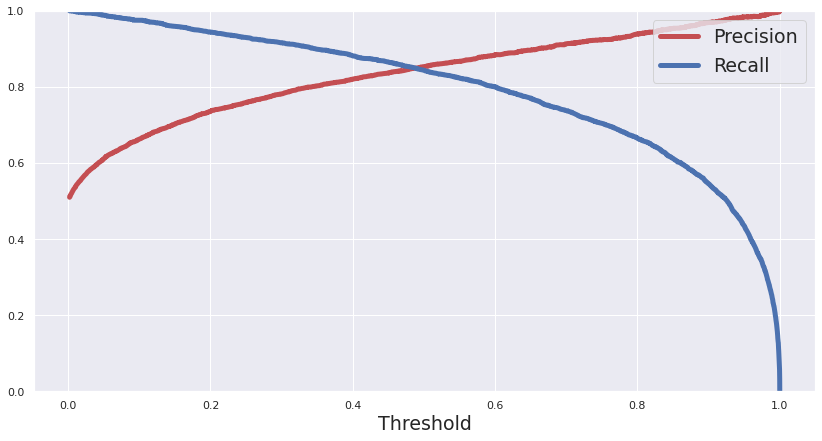

In [ ]:
from sklearn.metrics import precision_recall_curve

#y_scores = best_rfgs.predict_proba(X_valid)
#y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_valid11, pred3)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="Precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="Recall", linewidth=5)
    plt.xlabel("Threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

The accuracy score is better at 10th epoch compared to our first experiment. Thus, will try experiment 3 with regularization and drop out layers.

## M3: 3 Layers CNN

Batch Normalization -  Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

In [ ]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1),input_shape=input_shape))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(64, (3, 3), activation='relu' ))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model3.summary()

In [ ]:
# fitting a basic model
history3 = model3.fit(train_gen,
                    validation_data = valid_gen,
                    epochs = 10,
                    verbose=1, #for animated bar during epoch
                    callbacks = [earlystop, learning_rate_reduction])

Epoch 1/10
547/547 [==============================] - 908s 2s/step - loss: 0.5585 - accuracy: 0.7294 - val_loss: 0.5626 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 2/10
547/547 [==============================] - 912s 2s/step - loss: 0.4477 - accuracy: 0.7931 - val_loss: 0.5795 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 3/10
547/547 [==============================] - 893s 2s/step - loss: 0.3962 - accuracy: 0.8207 - val_loss: 0.4256 - val_accuracy: 0.8181 - lr: 0.0010
Epoch 4/10
547/547 [==============================] - 893s 2s/step - loss: 0.3609 - accuracy: 0.8436 - val_loss: 0.4523 - val_accuracy: 0.8089 - lr: 0.0010
Epoch 5/10
547/547 [==============================] - 887s 2s/step - loss: 0.3378 - accuracy: 0.8531 - val_loss: 0.3744 - val_accuracy: 0.8437 - lr: 0.0010
Epoch 6/10
547/547 [==============================] - 891s 2s/step - loss: 0.3155 - accuracy: 0.8635 - val_loss: 0.9474 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 7/10
547/547 [==============================] - ETA: 0s - 

In [ ]:
# expected output
y_valid = valid_data.category
y_pred=model3.predict_generator(generator=valid_gen, verbose=1)
pred = np.argmax(y_pred,axis = 1) # pick the class with highest probability
labels = (valid_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

235/235 [==============================] - 104s 439ms/step


Text(0.5, 1.0, 'Training and Validation Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and Validation Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

<Figure size 432x288 with 0 Axes>

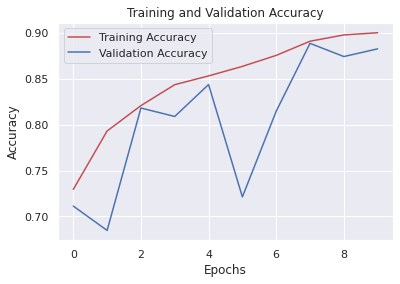

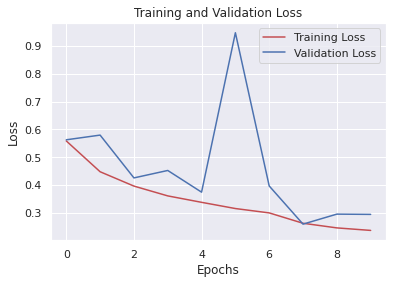

<Figure size 432x288 with 0 Axes>

In [ ]:


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
loss=history3.history['loss']
val_loss=history3.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "upper left")
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "upper right")
plt.figure()

In [ ]:
print(classification_report(y_valid, pred2))

              precision    recall  f1-score   support

         cat       0.85      0.93      0.89      3781
         dog       0.93      0.83      0.87      3719

    accuracy                           0.88      7500
   macro avg       0.89      0.88      0.88      7500
weighted avg       0.89      0.88      0.88      7500



Text(0.5, 1.05, 'Confusion Matrix : Actual v/s Predicted')

Text(0.5, 12.5, 'Predicted Value')

Text(30.5, 0.5, 'Actual Value')

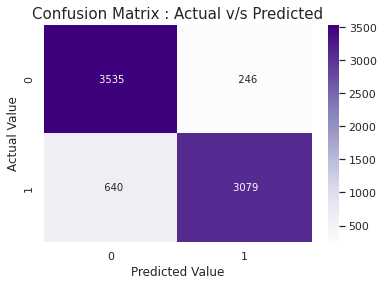

In [ ]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_valid, pred2),annot=True,fmt='5.0f',cmap="Purples")
plt.title('Confusion Matrix : Actual v/s Predicted', y=1.05, size=15)
#ax = fig.add_subplot(111)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_valid11 = le.fit_transform(y_valid)
#y_valid1 =  label_img(y_valid)
pred3 = pd.Series(y_pred[:,1])

<Figure size 1008x504 with 0 Axes>

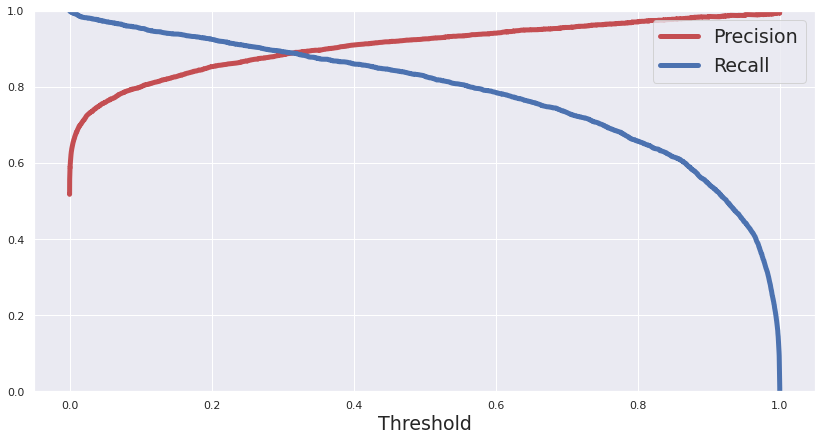

In [ ]:
from sklearn.metrics import precision_recall_curve

#y_scores = best_rfgs.predict_proba(X_valid)
#y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_valid11, pred3)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="Precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="Recall", linewidth=5)
    plt.xlabel("Threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

Clearly, this model fits the best with the highest accuracy and f1 score for cats as well as dogs .Kaggle log loss score was 0.24 , which means that the model performs well for test dataset as well.

##Kaggle Submission

In [ ]:
test_filenames = os.listdir("./test/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})

In [ ]:
test_df.head(5)

In [ ]:
test_image_gen = ImageDataGenerator(rescale=1/255.)

In [ ]:
test_gen = test_image_gen.flow_from_dataframe(
    test_df, 
    "./test/test",
    x_col='filename',
    y_col=None,
    target_size=(128,128),
    class_mode=None,
    batch_size=32,
    shuffle = False # not to shuffle the given data
)

In [ ]:
y_test1=model1.predict_generator(generator=test_gen, verbose=1)
pred_test1 = np.argmax(y_test1,axis = 1)

In [ ]:
# labelling data
labels1 = (train_gen.class_indices)
labels1 = dict((v,k) for k,v in labels1.items())
pred_test11 = [labels1[k] for k in pred_test1]

In [ ]:
submission1 = pd.DataFrame({'id':pd.Series(test_gen.filenames),
                           'label':pd.Series(y_test1[:,1])})
submission1['id'] = submission1.id.str.extract('(\d+)')
submission1['id'] = pd.to_numeric(submission1['id'])
submission1.to_csv("dogs_vs_cats_sub1.csv", index=False)

### M1: Kaggle Score: 0.41397
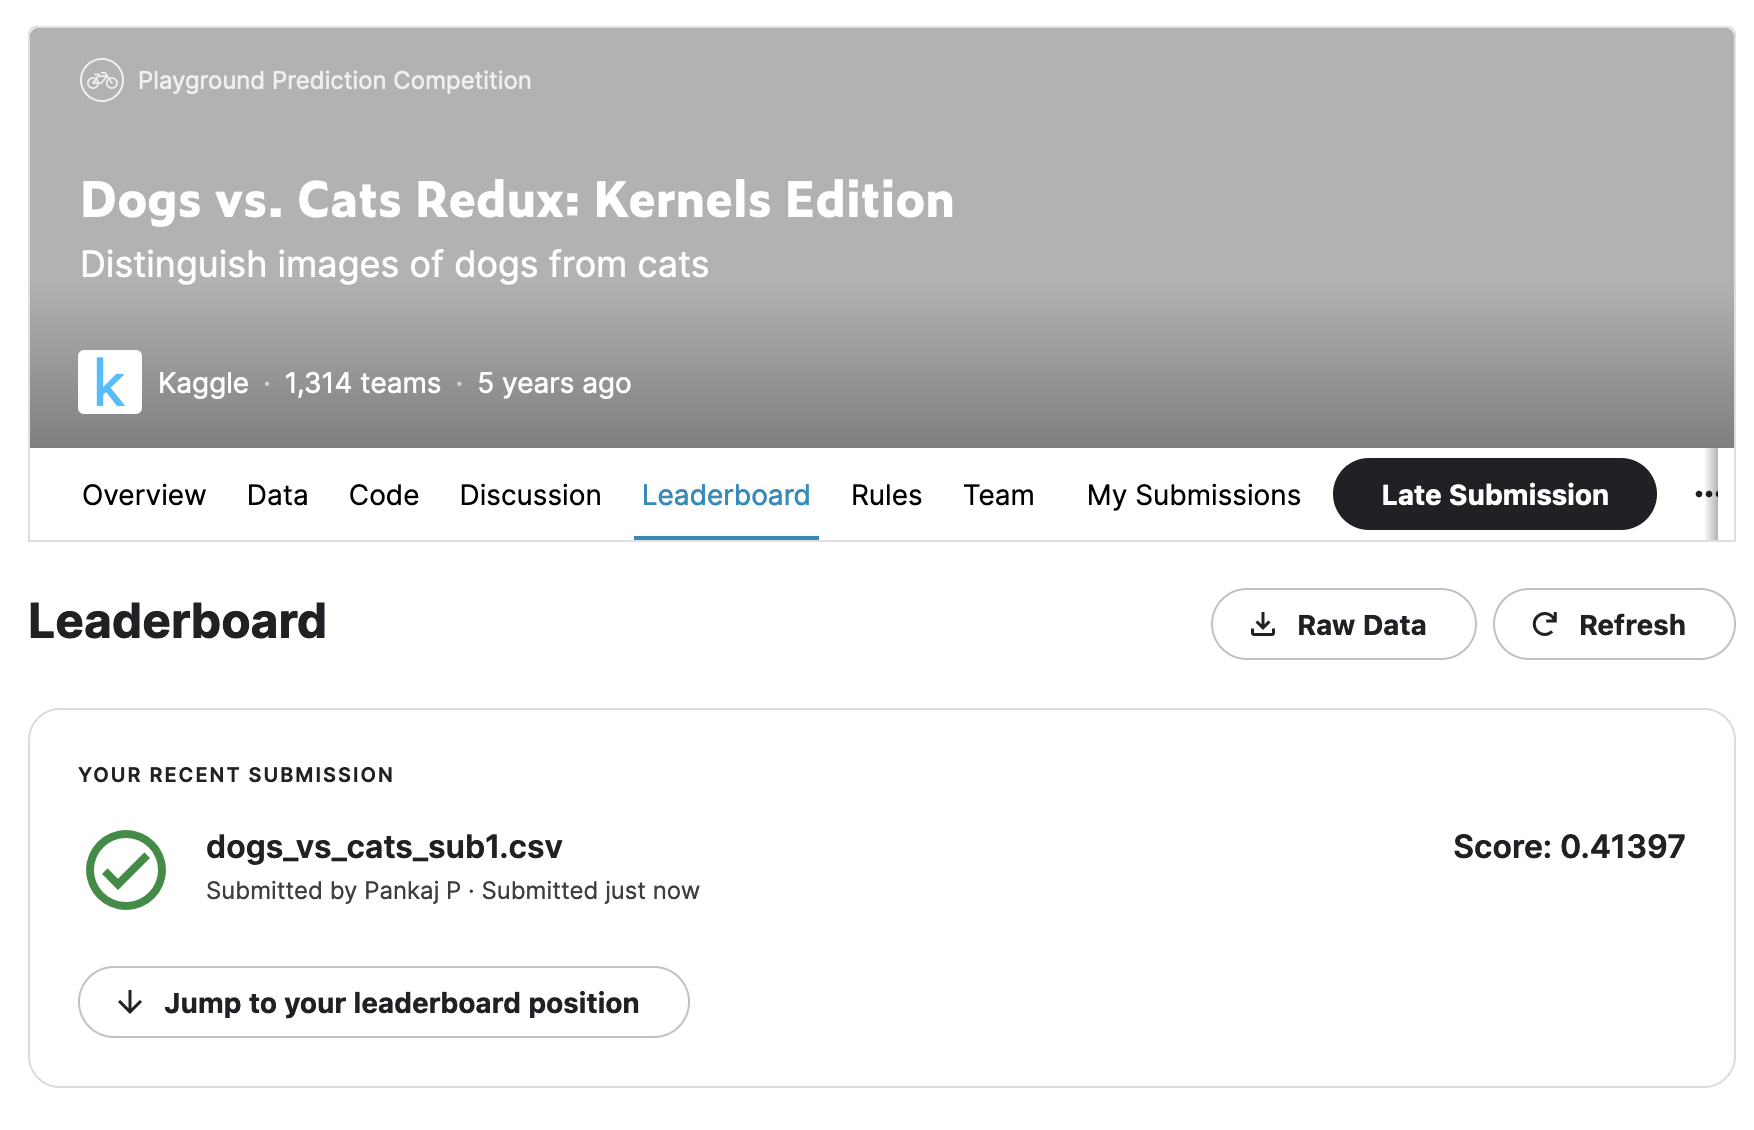 

In [ ]:
y_test2=model2.predict_generator(generator=test_gen, verbose=1)
pred_test2 = np.argmax(y_test2,axis = 1)

In [ ]:
# labelling data
labels2 = (train_gen.class_indices)
labels2 = dict((v,k) for k,v in labels2.items())
pred_test12= [labels2[k] for k in pred_test2]

In [ ]:
submission2 = pd.DataFrame({'id':pd.Series(test_gen.filenames),
                           'label':pd.Series(y_test2[:,1])})
submission2['id'] = submission2.id.str.extract('(\d+)')
submission2['id'] = pd.to_numeric(submission2['id'])
submission2.to_csv("dogs_vs_cats_sub2.csv", index=False)

###M2: Kaggle Score: 0.29240

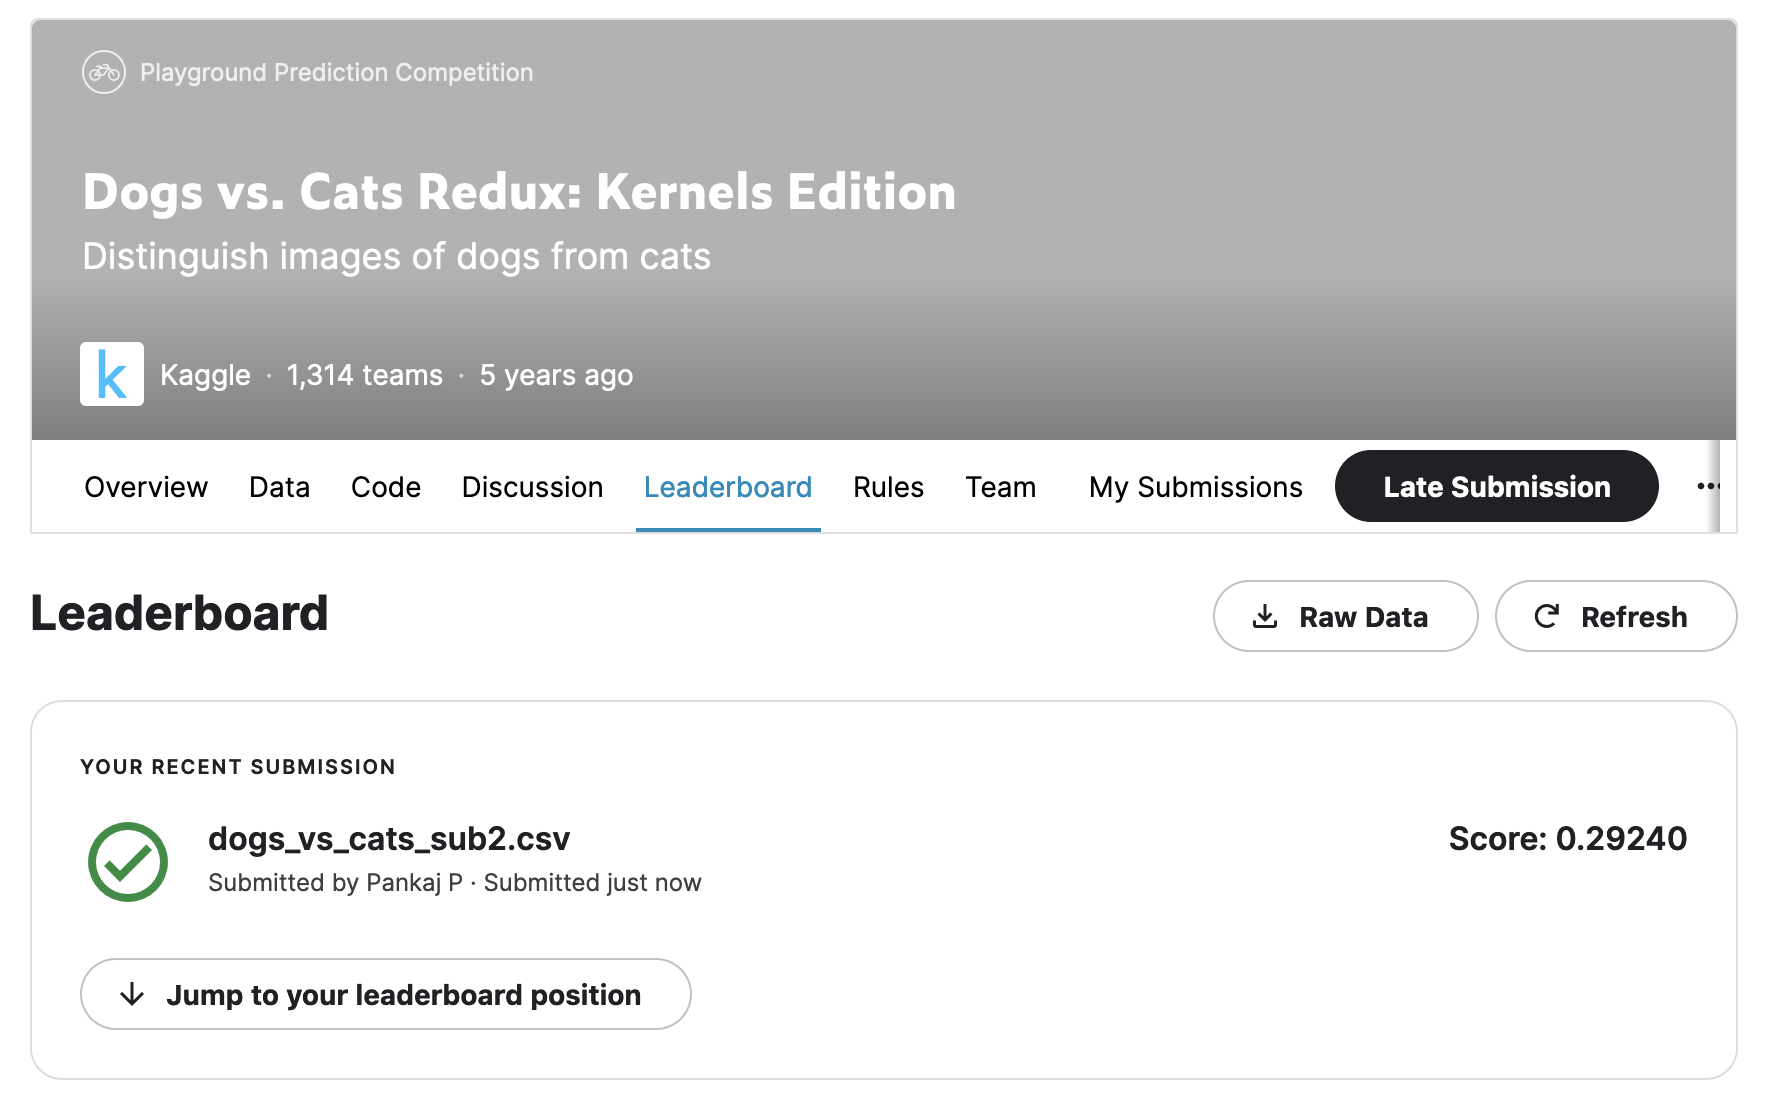

In [ ]:
y_test3=model3.predict_generator(generator=test_gen, verbose=1)
pred_test3 = np.argmax(y_test3,axis = 1)

#pred= model.predict_generator(validation_generator, verbose=1)
#predicted_class_indices=[1 if x >= 0.5 else 0 for x in pred]

In [ ]:
# labelling data
labels3 = (train_gen.class_indices)
labels3 = dict((v,k) for k,v in labels3.items())
pred_test13 = [labels3[k] for k in pred_test3]

In [ ]:
submission3 = pd.DataFrame({'id':pd.Series(test_gen.filenames),
                           'label':pd.Series(y_test3[:,1])})
submission3['id'] = submission3.id.str.extract('(\d+)')
submission3['id'] = pd.to_numeric(submission3['id'])
submission3.to_csv("dogs_vs_cats_sub3.csv", index=False)

###M3: Kaggle Score: 0.35020

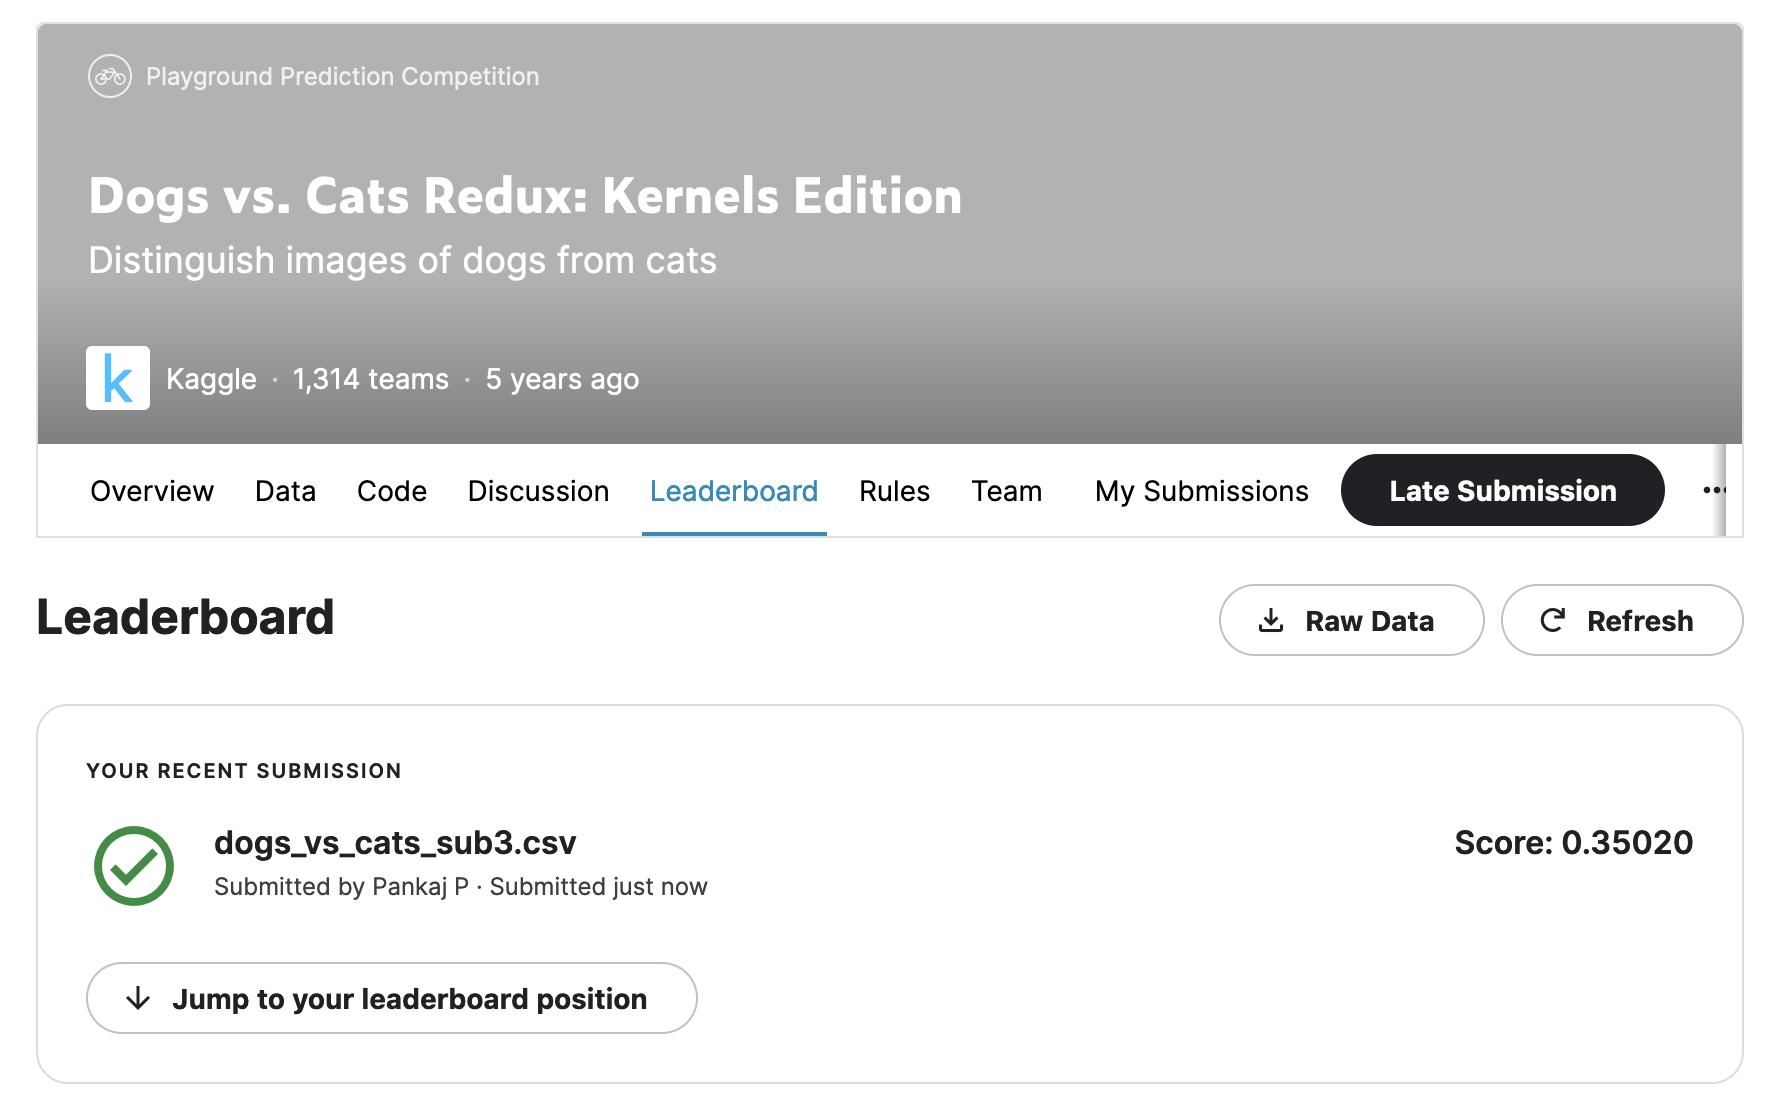